## Robust Regression with Clustering
The approach that we take in this section is to build a robust regression by mean of clustering. The process starts by applying a *proper* clustering method (number of cluster is large to make sure that the elbow criteria is passed). Two different outcomes are expected:
1. There are few clusters that contain the majority of data.
2. Dataset is distributed among clusters almost uniformly.

If the outcome 1 happens, the regression model of interest will be trained on the sorted clusters based on their population from large to small. The test error will be measured every time a new cluster is added to the training dataset. The accumulated clusters with minimum generalization error will be the final trained model.

If the outcome 2 happens, then there would be no preferance among the clusters. The best course of action would be similar to *cross validation* by taking one cluster of data out and train on the rests. The best model can be reached either by taking average (need to be spicific, if it is a decision tree based model the average of models does not mean anything), or exclude the cluster that when it is added to the training dataset increase the generalization error dramaticly.

### Form of outliers and distibution of data points


### Steps:
- [ ] Generate some dataset.
- [ ] Add a uniform noise to original data.
- [ ] Build a simple regression model
- [ ] Apply idea of multiple cluster clustering.
- [ ] Train the same model on clusters accumulatively.

### Two Scenario
Here we identify two specific forms of outliers:
1. Outliers are uniformly distributated in range of inliers
2. Outliers are isolated in the feature space

### Curse of Dimensionality
When the number of features is too large, the clustering method lose its reliability.
...

## Generating data with outliers (isolated outliers)
In this example outliers are completely isolated from the inliers.

In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as pl
# to pairplot
import seaborn as sns
# to generate random dataset (+outliers)
from sklearn.datasets import make_blobs, make_moons


In [2]:
rnd.seed(47)

### Generating Inliers
For now the target is a linear function of features.

In [3]:
# parameters 
size_data = 500
ratio_outliers = 0.1
size_outliers = int(ratio_outliers*size_data)
size_inliers = size_data - size_outliers

# Generate one cluster of data for inliers
X_in, _ = make_blobs(n_samples=size_inliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: linear function of features
y_in = a1*X_in[:,0] + a2*X_in[:,1] + rnd.rand(size_inliers)


### Generating outliers
Notice that the target value of outliers is a random number in the same expected range. This is a sensible assumption, otherwise if the target has a same form of functionality of the features, even out of range, lead to the same trained model.

In [4]:
# outliers
X_out, _ = make_blobs(n_samples=size_outliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: just a random noise in the same range of inlier data
y_out = (y_in.max() - y_in.min()) * rnd.rand(size_outliers) 

### Concatonate `inliers` and `outliers`

In [5]:
X = np.r_[X_in, X_out]
y = np.r_[y_in, y_out]

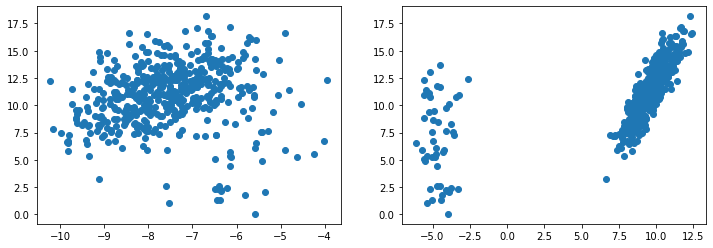

In [6]:
fig, ax = pl.subplots(1,2, figsize=(12,4))
ax[0].scatter(X[:,0], y)
ax[1].scatter(X[:,1], y)


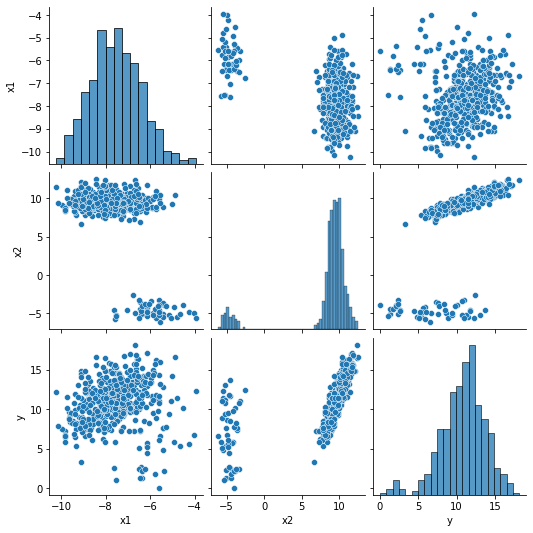

In [7]:
data = pd.DataFrame(np.c_[X,y], columns=['x1', 'x2','y'])
sns.pairplot(data)

From the `pairplot`, it is clear that features and target are not *unimodal* anymore.

## Training a model

### Without outlier treatment

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
lr = LinearRegression()

In [11]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [12]:
train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [13]:
print("train MAE: {:.3} and test MAE: {:.3}".format(train_mae, test_mae))
print("train score: {:.3} and test score: {:.3}".format(lr.score(X_train, y_train),
                                                        lr.score(X_test, y_test)))

train MAE: 1.37 and test MAE: 1.56
train score: 0.58 and test score: 0.534


## With outlier treatmet
- What is the best performance that one get if we remove outliers completely?
One thing that we need to be careful that in practice we can not know this score.

In [14]:
# make a train-test on inliers
X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, test_size=0.33, random_state=42)

In [15]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [16]:
print("train MAE: {:.3} and test MAE: {:.3}".format(train_mae, test_mae))
print("train score: {:.3} and test score: {:.3}".format(lr.score(X_train, y_train),
                                                        lr.score(X_test, y_test)))

train MAE: 0.234 and test MAE: 0.231
train score: 0.987 and test score: 0.987


### Clustering with large number of clusters
- [X] Apply clustering, make sure you pass elbow criteria.
- [X] Sort cluster based on their population.
- [X] Start training from high population accumulatively.
- [X] Measure generalization error.
- [X] Plot error agains clusters.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
from sklearn.cluster import KMeans

In [19]:
inertias = []
for n_cluster in range(2,15):
    km = KMeans(n_clusters=n_cluster)
    km.fit(X_train)
    inertias.append(km.inertia_)

Text(0, 0.5, 'Inertia')

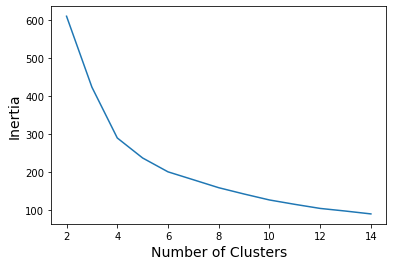

In [20]:
pl.plot(range(2,15), inertias)
pl.xlabel('Number of Clusters', fontsize=14)
pl.ylabel('Inertia', fontsize=14)

In [21]:
km = KMeans(n_clusters=10)
km.fit(X_train)

KMeans(n_clusters=10)

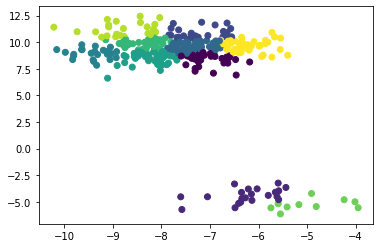

In [22]:
pl.scatter(X_train[:,0], X_train[:,1], c = km.labels_)

#### Population of clusters

In [23]:
cluster_populations = {i:km.labels_[km.labels_ == i].size for i in range(0,10)}

Sort clusters based on their population.

In [24]:
# sort cluster based on their population
cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), key=lambda el: el[1], reverse=True)]

In [25]:
cluster_sorted_key

[3, 5, 6, 9, 0, 2, 4, 8, 1, 7]

In [26]:
cm_train_score = []
test_score = []
for cl in cluster_sorted_key:
    if cl == cluster_sorted_key[0]:
        # initialize with the fist cluster
        X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
        y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
    else:
        X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
        y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]
        
    lr.fit(X_cum, y_cum)
    print("Cumulative Train Score: {:04.3f}, Test Score: {:04.3f}".format(lr.score(X_cum, y_cum), lr.score(X_test, y_test)))
    cm_train_score.append(lr.score(X_cum, y_cum))
    test_score.append(lr.score(X_test, y_test))

Cumulative Train Score: 0.913, Test Score: -6.035
Cumulative Train Score: 0.972, Test Score: -6.237
Cumulative Train Score: 0.988, Test Score: -6.394
Cumulative Train Score: 0.763, Test Score: 0.498
Cumulative Train Score: 0.740, Test Score: 0.508
Cumulative Train Score: 0.719, Test Score: 0.522
Cumulative Train Score: 0.582, Test Score: 0.530
Cumulative Train Score: 0.600, Test Score: 0.537
Cumulative Train Score: 0.604, Test Score: 0.510
Cumulative Train Score: 0.552, Test Score: 0.534


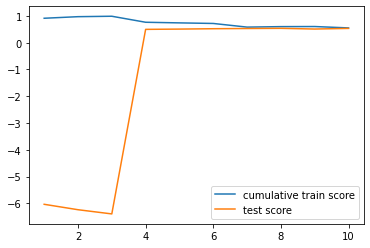

In [27]:
pl.plot(range(1,11),cm_train_score, label='cumulative train score')
pl.plot(range(1,11),test_score, label='test score' )
pl.legend()

### Observation:

It is not fair to compare the result against pure inliers.  It is strange that inclusion of more data, independent of their clusters, lead to a better score. However, notice that when the last two cluster were added to the training dataset, the ccumulative train score is less than test score. The train and test score can swap many times, but we looking for a swap when both are stable. The swap between train and test score can happen differently depending on population of outliers and degree of their localization.

In [28]:
def cluster_regression(X, y):
    """ Performs clustering on dataset. Learn a regression model over clusters accumulatively.
    
    input:
    ------
    X: np.array, design matrix
    y: np.array, target vector (labels)
    
    output:
    -------
    model: sklearn trained model, best model
    """
    # TODO: 
    # - right way to decide the number of clusters
    # - devide to validation, test, cross validation 
    # ...
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=42)

    # Clustering
    n_clusters = 10
    km = KMeans(n_clusters = n_clusters)
    km.fit(X_train)
    # calculate population of clusters
    cluster_populations = {i:km.labels_[km.labels_ == i].size 
                           for i in range(0,n_clusters)}
    
    # sort cluster based on their population
    cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), 
                                               key=lambda el: el[1], 
                                               reverse=True)]
    # Regression
    cm_train_score = []
    test_score = []
    for cl in cluster_sorted_key:
        if cl == cluster_sorted_key[0]:
            # initialize with the fist cluster
            X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
            y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
        else:
            X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
            y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]

        lr.fit(X_cum, y_cum)
        print("Cumulative Train Score: {:04.3f}, Test Score: {:04.3f}".\
                                            format(lr.score(X_cum, y_cum), 
                                                   lr.score(X_test, y_test)))
        cm_train_score.append(lr.score(X_cum, y_cum))
        test_score.append(lr.score(X_test, y_test))

In [29]:
cluster_regression(X,y)

Cumulative Train Score: 0.907, Test Score: -6.384
Cumulative Train Score: 0.965, Test Score: -6.165
Cumulative Train Score: 0.985, Test Score: -6.311
Cumulative Train Score: 0.505, Test Score: 0.536
Cumulative Train Score: 0.437, Test Score: 0.492
Cumulative Train Score: 0.500, Test Score: 0.518
Cumulative Train Score: 0.503, Test Score: 0.516
Cumulative Train Score: 0.561, Test Score: 0.518
Cumulative Train Score: 0.587, Test Score: 0.537
Cumulative Train Score: 0.580, Test Score: 0.534


In [30]:
import sys  
sys.path.insert(0, '/Users/cm-amin/projects/outlier_handling/')
from src.cluster_regression import cluster_regression

In [31]:
cluster_regression(X,y)

Cumulative Train Score: 0.879, Test Score: -6.117
Cumulative Train Score: 0.970, Test Score: -6.299
Cumulative Train Score: 0.970, Test Score: -6.475
Cumulative Train Score: 0.596, Test Score: 0.537
Cumulative Train Score: 0.663, Test Score: 0.539
Cumulative Train Score: 0.703, Test Score: 0.524
Cumulative Train Score: 0.649, Test Score: 0.512
Cumulative Train Score: 0.655, Test Score: 0.472
Cumulative Train Score: 0.622, Test Score: 0.518
Cumulative Train Score: 0.580, Test Score: 0.534
